# Predict house pricing

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [2]:
data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print(data.shape[0])
data.isnull().sum()

1460


Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [4]:
# Пропуск значений в этих колонках означает отсутствие чего-то
data['FireplaceQu'].fillna('None', inplace=True)
data['Alley'].fillna('None', inplace=True)
data['PoolQC'].fillna('None', inplace=True)
data['Fence'].fillna('None', inplace=True)
data['MiscFeature'].fillna('None', inplace=True)
data['BsmtQual'].fillna('None', inplace=True)
data['BsmtCond'].fillna('None', inplace=True)
data['BsmtExposure'].fillna('None', inplace=True)
data['BsmtFinType1'].fillna('None', inplace=True)
data['BsmtFinType2'].fillna('None', inplace=True)
data['GarageType'].fillna('None', inplace=True)
data['GarageFinish'].fillna('None', inplace=True)
data['GarageYrBlt'].fillna(0, inplace=True)
data['GarageQual'].fillna('None', inplace=True)
data['GarageCond'].fillna('None', inplace=True)
data['MasVnrType'].fillna('None', inplace=True)
data['MasVnrArea'].fillna(0, inplace=True)

In [5]:
train = data.drop(columns=['Id'])
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [6]:
import numpy as np
temp = list(train.dtypes[train.dtypes == 'int64'].reset_index()['index'])
numeric = list(np.reshape(temp, (1, len(temp))))
numeric

[array(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
        'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
        'MoSold', 'YrSold', 'SalePrice'], dtype='<U13')]

In [7]:
train.dropna(inplace=True)
train.shape

(1200, 80)

In [8]:
train.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64

In [9]:
objects = list(train.dtypes[train.dtypes == 'object'].reset_index()['index'])
train[objects].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


### Обработаем категориальные данные с помощью OneHotEncoder --------------------------------------------------------------------------

In [10]:
x = train[objects]
encoder = OneHotEncoder(handle_unknown='ignore')

encoder_df = pd.DataFrame(encoder.fit_transform(x).toarray())
print(encoder_df.shape)
encoder_df.columns = [str(i) for i in range(1, 259)]
encoder_df = encoder_df.astype('int64')

final_df = pd.concat([train.reset_index(drop=True), encoder_df], axis=1)

print(final_df.shape)
final_df.head()

(1200, 258)
(1200, 338)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,249,250,251,252,253,254,255,256,257,258
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,0,1,0,0,0,0,1,0
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,0,1,0,0,0,0,1,0
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,0,1,0,0,0,0,1,0
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,0,1,1,0,0,0,0,0
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,0,1,0,0,0,0,1,0


In [11]:
final_df.drop(columns=objects, inplace=True)
final_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,249,250,251,252,253,254,255,256,257,258
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


In [12]:
final_df.dtypes.value_counts()

int64      292
float64      3
dtype: int64

### Нормализуем данные --------------------------------------------------------------------------

In [13]:
X_train, X_test, y_train, y_test = train_test_split(final_df.drop(columns=['SalePrice']), final_df['SalePrice'])
transformer = Normalizer().fit(final_df.iloc[:, 0:36])
norm_final_df = final_df
norm_final_df = pd.concat([pd.DataFrame(transformer.transform(norm_final_df.iloc[:, 0:36])), final_df.iloc[:, 37:], final_df['SalePrice']], axis=1)
norm_final_df

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,SalePrice
0,0.006206,0.006724,0.874061,0.000724,0.000517,0.207189,0.207189,0.020274,0.073028,0.000000,...,0,0,1,0,0,0,0,1,0,208500
1,0.001873,0.007492,0.899027,0.000562,0.000749,0.185050,0.185050,0.000000,0.091588,0.000000,...,0,0,1,0,0,0,0,1,0,181500
2,0.004914,0.005569,0.921408,0.000573,0.000410,0.163888,0.163970,0.013268,0.039805,0.000000,...,0,0,1,0,0,0,0,1,0,223500
3,0.006596,0.005654,0.899920,0.000660,0.000471,0.180455,0.185638,0.000000,0.020354,0.000000,...,0,0,1,1,0,0,0,0,0,140000
4,0.003961,0.005545,0.941327,0.000528,0.000330,0.132023,0.132023,0.023104,0.043238,0.000000,...,0,0,1,0,0,0,0,1,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.006514,0.006731,0.859535,0.000651,0.000543,0.217028,0.217137,0.000000,0.000000,0.000000,...,0,0,1,0,0,0,0,1,0,175000
1196,0.001408,0.005984,0.927537,0.000422,0.000422,0.139254,0.139958,0.008378,0.055617,0.011475,...,0,0,1,0,0,0,0,1,0,210000
1197,0.006554,0.006180,0.846603,0.000655,0.000843,0.181736,0.187822,0.000000,0.025748,0.000000,...,0,0,1,0,0,0,0,1,0,266500
1198,0.001867,0.006346,0.906880,0.000467,0.000560,0.181992,0.186285,0.000000,0.004573,0.096036,...,0,0,1,0,0,0,0,1,0,142125


In [14]:
norm_final_df.columns = [str(i) for i in range(len(norm_final_df.columns))]
norm_final_df.head()

,0,1,2,3,4,5,6,7,8,9,...,285,286,287,288,289,290,291,292,293,294
0,0.006206,0.006724,0.874061,0.000724,0.000517,0.207189,0.207189,0.020274,0.073028,0.0,...,0,0,1,0,0,0,0,1,0,208500
1,0.001873,0.007492,0.899027,0.000562,0.000749,0.185050,0.185050,0.000000,0.091588,0.0,...,0,0,1,0,0,0,0,1,0,181500
2,0.004914,0.005569,0.921408,0.000573,0.000410,0.163888,0.163970,0.013268,0.039805,0.0,...,0,0,1,0,0,0,0,1,0,223500
3,0.006596,0.005654,0.899920,0.000660,0.000471,0.180455,0.185638,0.000000,0.020354,0.0,...,0,0,1,1,0,0,0,0,0,140000
4,0.003961,0.005545,0.941327,0.000528,0.000330,0.132023,0.132023,0.023104,0.043238,0.0,...,0,0,1,0,0,0,0,1,0,250000


In [15]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(norm_final_df.drop(columns=['294']), norm_final_df['294'])

### Обучаем модели

In [16]:
lr = LinearRegression().fit(X_train, y_train)
gb = xgb.XGBRegressor().fit(X_train, y_train)

lr_norm = LinearRegression().fit(X_train_norm, y_train_norm)
gb_norm = xgb.XGBRegressor().fit(X_train_norm, y_train_norm)

In [17]:
lr_mae = metrics.mean_absolute_error(y_test, lr.predict(X_test))
gb_mae = metrics.mean_absolute_error(y_test, gb.predict(X_test))
lr_mae_norm = metrics.mean_absolute_error(y_test_norm, lr_norm.predict(X_test_norm))
gb_mae_norm = metrics.mean_absolute_error(y_test_norm, gb_norm.predict(X_test_norm))
lr_r2 = metrics.r2_score(y_test, lr.predict(X_test))
gb_r2 = metrics.r2_score(y_test, gb.predict(X_test))
lr_r2_norm = metrics.r2_score(y_test_norm, lr_norm.predict(X_test_norm))
gb_r2_norm = metrics.r2_score(y_test_norm, gb_norm.predict(X_test_norm))

In [18]:
models = ['lr', 'gb', 'lr_norm', 'gb_norm']
scores = np.reshape([lr_mae, gb_mae, lr_mae_norm, gb_mae_norm, lr_r2, gb_r2, lr_r2_norm, gb_r2_norm],(2, 4))
pd.DataFrame(scores, columns=models, index=['MAE', 'R2'])

,lr,gb,lr_norm,gb_norm
MAE,20162.881628,18294.043099,1.527140e+14,24176.751354
R2,0.776194,0.813324,-4.107439e+20,0.768255


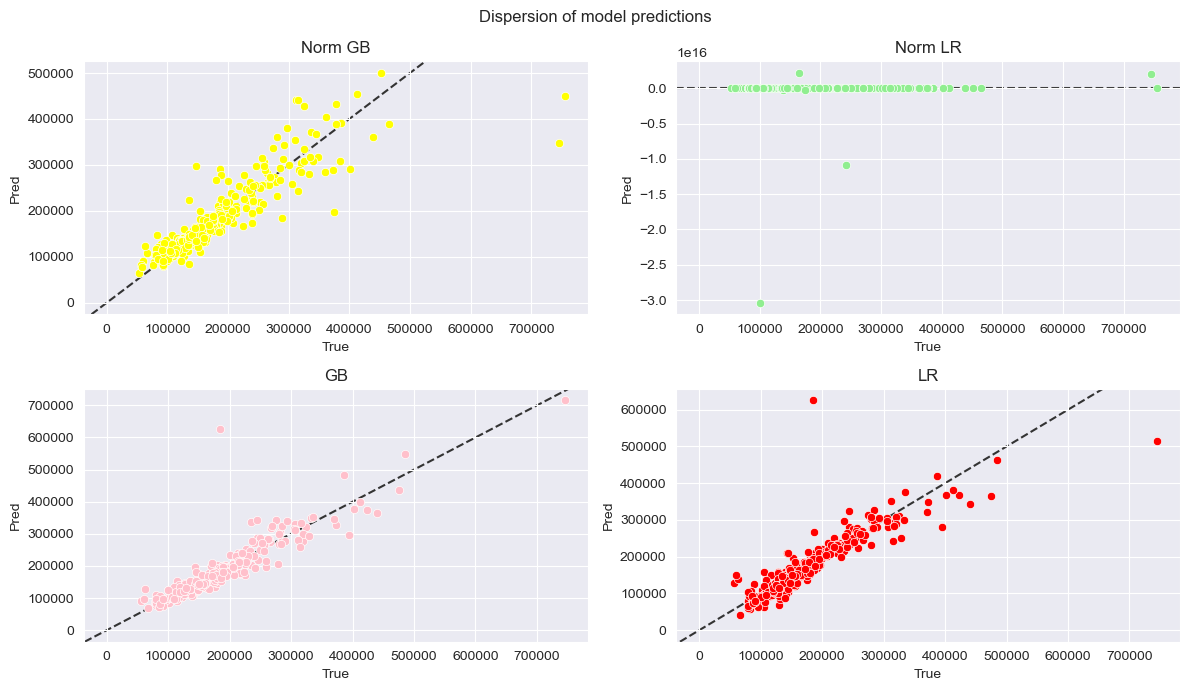

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12,7))
sns.scatterplot(x=y_test_norm, y=gb_norm.predict(X_test_norm), ax=axs[0,0], color='yellow')
sns.scatterplot(x=y_test_norm, y=lr_norm.predict(X_test_norm), ax=axs[0,1], color='lightgreen')
sns.scatterplot(x=y_test, y=gb.predict(X_test), ax=axs[1,0], color='pink')
sns.scatterplot(x=y_test, y=lr.predict(X_test), ax=axs[1,1], color='red')

for ax in axs.flat:
    ax.axline((0, 0),(1,1), c=".2", ls="--", zorder=0)

fig.suptitle('Dispersion of model predictions')
axs[0,0].set_title('Norm GB')
axs[0,1].set_title('Norm LR')
axs[1,0].set_title('GB')
axs[1,1].set_title('LR')
for ax in axs.flat:
    ax.set(xlabel='True', ylabel='Pred')
fig.tight_layout()

plt.show()

In [25]:
GB_parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [100,500,1000, 1500],
              'max_depth'    : [4,6,8,10]
              }
LR_parameters = {"fit_intercept": [True, False]
              }

In [28]:
gb_grid = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=GB_parameters).fit(final_df.drop(columns=['SalePrice']), final_df['SalePrice'])
lr_grid = GridSearchCV(estimator=LinearRegression(), param_grid=LR_parameters).fit(final_df.drop(columns=['SalePrice']), final_df['SalePrice'])
print(f'gb best params: {gb_grid.best_params_}')
print(f'gb best score: {gb_grid.best_score_}')
print(f'lr best params: {lr_grid.best_params_}')
print(f'lr best score: {lr_grid.best_score_}')

gb best params: {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 1500, 'subsample': 0.5}
gb best score: 0.8837156767773283
lr best params: {'fit_intercept': True}
lr best score: 0.6437996588305214


In [29]:
gb_grid_norm = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=GB_parameters).fit(norm_final_df.drop(columns=['294']), norm_final_df['294'])
print(f'gb best params: {gb_grid_norm.best_params_}')
print(f'gb best score: {gb_grid_norm.best_score_}')

gb best params: {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 1500, 'subsample': 0.5}
gb best score: 0.859265983930668


In [30]:
gb = xgb.XGBRegressor(learning_rate = 0.02, max_depth=4, n_estimators=1500, subsample=0.5)
gb.fit(final_df.drop(columns=['SalePrice']), final_df['SalePrice'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Test -----------------------------------------

In [60]:
test = pd.read_csv('test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [61]:
print(test.shape)
test.isna().sum()

(1459, 80)


Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64

In [62]:
test['FireplaceQu'].fillna('None', inplace=True)
test['Alley'].fillna('None', inplace=True)
test['PoolQC'].fillna('None', inplace=True)
test['Fence'].fillna('None', inplace=True)
test['MiscFeature'].fillna('None', inplace=True)
test['BsmtQual'].fillna('None', inplace=True)
test['BsmtCond'].fillna('None', inplace=True)
test['BsmtExposure'].fillna('None', inplace=True)
test['BsmtFinType1'].fillna('None', inplace=True)
test['BsmtFinType2'].fillna('None', inplace=True)
test['GarageType'].fillna('None', inplace=True)
test['GarageFinish'].fillna('None', inplace=True)
test['GarageYrBlt'].fillna(0, inplace=True)
test['GarageQual'].fillna('None', inplace=True)
test['GarageCond'].fillna('None', inplace=True)
test['MasVnrType'].fillna('None', inplace=True)
test['MasVnrArea'].fillna(0, inplace=True)
test = test.fillna(test.mode().iloc[0])
result = test['Id']
test.drop(columns=['Id'], inplace=True)

### onehot

In [63]:
encoder_df = pd.DataFrame(encoder.transform(test[objects]).toarray())
encoder_df.columns = [str(i) for i in range(1, 259)]
encoder_df = encoder_df.astype('int64')

final_df = pd.concat([test.reset_index(drop=True), encoder_df], axis=1)

print(final_df.shape)
final_df.drop(columns=objects, inplace=True)
final_df.head()

(1459, 337)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,249,250,251,252,253,254,255,256,257,258
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0,0,0,1,0,0,0,0,1,0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,0,0,0,1,0,0,0,0,1,0
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [64]:
preds = gb.predict(final_df)
result = pd.concat([result, pd.DataFrame(preds)], axis=1)
result.columns = ['Id', 'SalePrice']
result.head()

,Id,SalePrice
0,1461,125291.664062
1,1462,158708.875000
2,1463,184675.484375
3,1464,193609.765625
4,1465,194694.281250


In [67]:
result.to_csv('result.csv', index=False)